<h1>Содержание<span class="tocSkip"></span></h1>
</li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Gradient-Boosting-Decision-Tree" data-toc-modified-id="Gradient-Boosting-Decision-Tree-3.0.2"><span class="toc-item-num">3.0.2&nbsp;&nbsp;</span>Gradient Boosting Decision Tree</a></span></li><li><span><a href="#Случайный-лес-LightGBM" data-toc-modified-id="Случайный-лес-LightGBM-3.0.3"><span class="toc-item-num">3.0.3&nbsp;&nbsp;</span>Случайный лес LightGBM</a></span></li></ul></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Gradient-Boosting-Decision-Tree" data-toc-modified-id="Gradient-Boosting-Decision-Tree-4.0.2"><span class="toc-item-num">4.0.2&nbsp;&nbsp;</span>Gradient Boosting Decision Tree</a></span></li><li><span><a href="#Случайный-лес-LightGBM" data-toc-modified-id="Случайный-лес-LightGBM-4.0.3"><span class="toc-item-num">4.0.3&nbsp;&nbsp;</span>Случайный лес LightGBM</a></span></li></ul></li></ul></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [67]:
# !pip install pandas-profiling

In [68]:
# ! pip install lightgbm

In [69]:
# Загрузим библиотеки

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas_profiling
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [70]:
# Загрузим данные

taxi = pd.read_csv("taxi.csv", index_col=["datetime"], parse_dates=["datetime"])
taxi

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ

In [71]:
# Изучим данные

pandas_profiling.ProfileReport(taxi)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Данные заказов такси с 1 марта 2018 года по 31 августа 2018 года. Столбец num_orders имеет 2%(537) 0 значений. 26496 строк всего. Шаг временного ряда 10 минут.

In [72]:
# Выполним ресемплирование по 1 часу

taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()
taxi.info()
print(taxi.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [73]:
# Проверим корректность ресемплирования

26496 / 6

4416.0

In [74]:
# Изучим данные еще раз

pandas_profiling.ProfileReport(taxi)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

В среднем такси заказывают Mean=84.4227808 раза, Minimum=0, Maximum=462

<AxesSubplot:xlabel='datetime'>

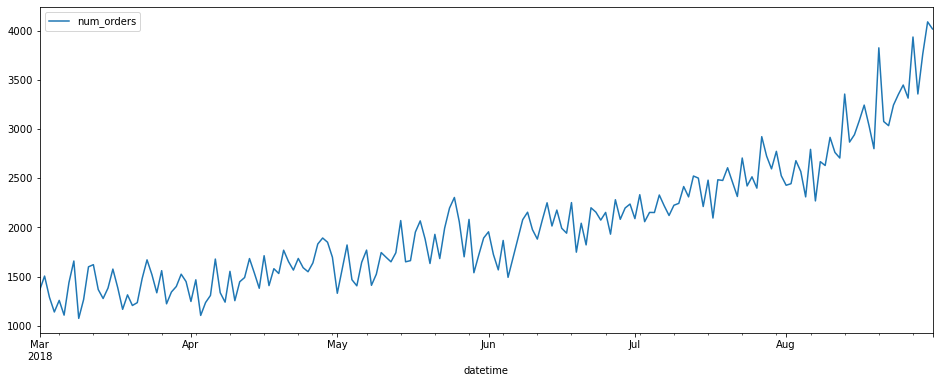

In [75]:
# Изучим, как изменяются данные за весь период времени

plt.figure(figsize=(16, 6))
taxi.resample('1D').sum().plot(ax=plt.gca())

Наш временной ряд нестационарный. Пик заказов приходится на лето. Результат ожидаемый, ведь это такси из аэропортов. Люди едут в отпуск и обратно. Наш тестовый временной ряд находится в промежутке '2018-08-14':'2018-08-31'. Сделаем его декомпозицию.

<AxesSubplot:xlabel='datetime'>

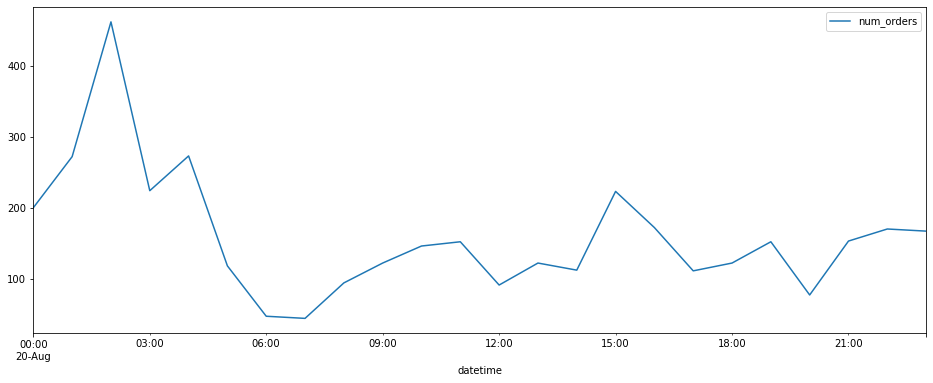

In [76]:
# Изучим временной ряд одного дня

plt.figure(figsize=(16, 6))
taxi['2018-08-20 00:00:00':'2018-08-20 23:00:00'].plot(ax=plt.gca())

Есть пик около 01-00. Минимум заказов приходится на 6 утра. Можно предположить, что это нюансы расписания полетов.

<AxesSubplot:xlabel='datetime'>

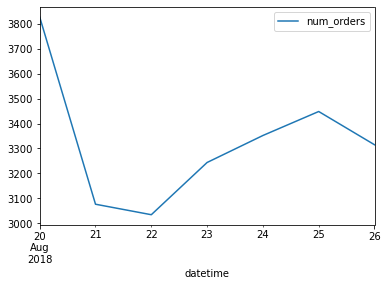

In [77]:
# Посмотрим на данные в разрезе недели

taxi_w = taxi['2018-08-20':'2018-08-26']
taxi_w = taxi_w.resample('1D').sum() # < напишите код здесь >
taxi_w.plot()

На недельном графике виден пик в понедельник. Скорее всего это всплеск деловой активности в начале недели. Люди разлетаются по командировкам. К среде наблюдается минимум, потом опять увеличение к выходным - люди летят на выходные.

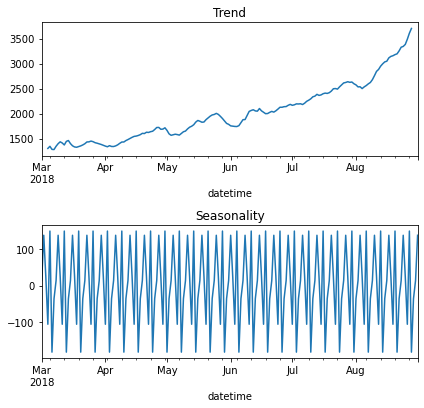

In [78]:
# Разложим временной ряд на тренд, сезонность и остаток

decomposed = seasonal_decompose(taxi.resample('1D').sum())

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

На графиках хорошо виден тренд года. К лету число заказов растет. На графике сезонности хорошо видны недельные колебания, их описали выше.

<AxesSubplot:xlabel='datetime'>

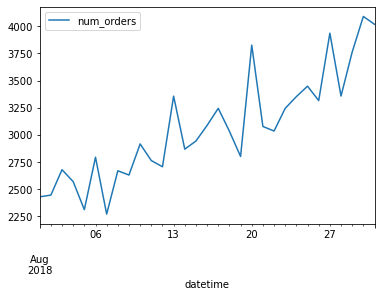

In [79]:
# Посмотрим на данные в разрезе месяца

taxi.resample('1D').sum().rolling(1).mean()['2018-08-01':'2018-08-31'].plot()

На месячном графике можно увидеть тренд увеличения заказов к концу месяца.

### Вывод:
* мы изучили основные тренды. За период с марта по август голичество заказов такси растет. Есть пик в пятницу. Наш временной ряд нестационарный. Необходимо преобразование.

## Обучение

In [80]:
# Напишем функцию для содания признаков

def make_features(data, max_lag, rolling_mean_size,column):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [81]:
# Сделаем временной ряд стационарным

df_preproccessed = taxi - taxi.shift(fill_value=taxi.iloc[0,0])
df_preproccessed

,num_orders
datetime,
2018-03-01 00:00:00,0
2018-03-01 01:00:00,-39
2018-03-01 02:00:00,-14
2018-03-01 03:00:00,-5
2018-03-01 04:00:00,-23
...,...
2018-08-31 19:00:00,-71
2018-08-31 20:00:00,18
2018-08-31 21:00:00,5


In [82]:
# Применим функцию для создания признаков. Изучив дневной график, можно предположить 8 частей. 
# Берем скользящее среднее по 8 значениям. Удаляем значения Nan.

make_features(df_preproccessed,100,8,'num_orders')
df_preproccessed.dropna(inplace = True)

In [83]:
# Разобьем выборку на 3 части. 10% тестовая, 10% валидация, 80% обучающая

# Обучающая и промежуточная
df_train, df_inter = train_test_split(df_preproccessed, shuffle=False, test_size=0.2, random_state=12345)

# 

df_valid, df_test = train_test_split(df_inter, shuffle=False, test_size=0.50, random_state=12345)

In [84]:
df_train

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,-17,2018,3,5,0,19.0,-144.0,90.0,18.0,-15.0,...,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,0.0,-0.625
2018-03-05 05:00:00,-18,2018,3,5,0,-17.0,19.0,-144.0,90.0,18.0,...,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-39.0,-5.375
2018-03-05 06:00:00,-13,2018,3,5,0,-18.0,-17.0,19.0,-144.0,90.0,...,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-14.0,-7.375
2018-03-05 07:00:00,11,2018,3,5,0,-13.0,-18.0,-17.0,19.0,-144.0,...,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-5.0,-10.000
2018-03-05 08:00:00,17,2018,3,5,0,11.0,-13.0,-18.0,-17.0,19.0,...,-66.0,32.0,-5.0,35.0,19.0,3.0,6.0,-37.0,-23.0,-6.750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-26 19:00:00,-13,2018,7,26,3,-29.0,-29.0,38.0,51.0,-17.0,...,50.0,1.0,5.0,44.0,3.0,-76.0,-8.0,22.0,0.0,-7.250
2018-07-26 20:00:00,-2,2018,7,26,3,-13.0,-29.0,-29.0,38.0,51.0,...,90.0,50.0,1.0,5.0,44.0,3.0,-76.0,-8.0,22.0,-1.875
2018-07-26 21:00:00,21,2018,7,26,3,-2.0,-13.0,-29.0,-29.0,38.0,...,-110.0,90.0,50.0,1.0,5.0,44.0,3.0,-76.0,-8.0,-4.125


Датафрейм получается не очень красивый, но экспериментально попробовав несколько вариантов, получается, что при увеличении количества отстающих значений увеличивается качество предсказаний. Остановился в итоге на значении 100.

In [85]:
# Разобьем наш датасет на обучающий и целевой признаки

features_train = df_train.drop(['num_orders'], axis=1)
target_train = df_train['num_orders']

features_valid = df_valid.drop(['num_orders'], axis=1)  
target_valid = df_valid['num_orders']

features_test = df_test.drop(['num_orders'], axis=1)  
target_test = df_test['num_orders']

In [86]:
# выведем размерности полученных переменных

var_list = [features_train, features_valid, features_test, target_train, target_valid, target_test]
for var in var_list:
    print(var.shape)

(3452, 105)
(432, 105)
(432, 105)
(3452,)
(432,)
(432,)


#### LinearRegression

In [87]:
# Создадим модель линейной регрессии, проверим на валидации, получим значение RMSE

model_lr = LinearRegression().fit(features_train, target_train)
predictions = model_lr.predict(features_valid)
print('RMSE:','{:.2f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 29.96


#### Gradient Boosting Decision Tree

In [88]:
hyper_params = {
    'learning_rate': 0.1,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "num_iterations": 300,
}
grad_bust_dt = lgb.LGBMRegressor(**hyper_params)
grad_bust_dt.fit(features_train, target_train,
        eval_set=[(features_train, target_train)],
        eval_metric='rmse',
        early_stopping_rounds=10, verbose = 10)

[10]	training's rmse: 24.9411
[20]	training's rmse: 20.736
[30]	training's rmse: 17.9885
[40]	training's rmse: 15.9384
[50]	training's rmse: 14.3627
[60]	training's rmse: 13.028
[70]	training's rmse: 11.8847
[80]	training's rmse: 10.9126
[90]	training's rmse: 10.024
[100]	training's rmse: 9.25071
[110]	training's rmse: 8.58299
[120]	training's rmse: 7.96995
[130]	training's rmse: 7.38917
[140]	training's rmse: 6.84482
[150]	training's rmse: 6.37415
[160]	training's rmse: 5.92379
[170]	training's rmse: 5.51034
[180]	training's rmse: 5.16407
[190]	training's rmse: 4.80563
[200]	training's rmse: 4.48707
[210]	training's rmse: 4.20718
[220]	training's rmse: 3.92652
[230]	training's rmse: 3.65101
[240]	training's rmse: 3.42182
[250]	training's rmse: 3.19342
[260]	training's rmse: 3.00579
[270]	training's rmse: 2.79978
[280]	training's rmse: 2.61218
[290]	training's rmse: 2.44447
[300]	training's rmse: 2.27759


LGBMRegressor(metric='rmse', num_iterations=300, objective='regression',
              task='train')

In [89]:
# Проверим на валидационной выборке, получим RMSE

predictions = grad_bust_dt.predict(features_valid)
print('RMSE:','{:.2f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 34.04


#### Случайный лес LightGBM

In [90]:
my_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [91]:
# Подберем гиперпараметры, применим TimeSeriesSplit

def get_best_params(features, target, model, parameters):

    #Подберём лучшие параметры модели с помощью RandomizedSearchCV
    cv = TimeSeriesSplit(n_splits=5)
    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = parameters,
                             scoring=my_scorer, cv = cv,
                             random_state = 124)
    search = clf.fit(features, target)
    print('Лучшие параметры: ', search.best_params_)

In [92]:
%time
parameters ={'learning_rate':np.arange(0.1, 0.5, 0.1),
             'n_estimators':np.arange(10, 200, 10),
                'max_depth':np.arange(1,20,1)}
lgbm = lgb.LGBMRegressor(random_state=12345)
get_best_params(features_train, target_train, lgbm, parameters)

Wall time: 0 ns
Лучшие параметры:  {'n_estimators': 190, 'max_depth': 15, 'learning_rate': 0.1}


In [93]:
lgbm = lgb.LGBMRegressor(max_depth=15, 
                         learning_rate=0.1, 
                         n_estimators=190, 
                         random_state=12345).fit(features_train, target_train)

In [94]:
# # Проверим на валидационной выборке, получим RMSE

predictions = lgbm.predict(features_valid)
print('RMSE:','{:.2f}'.format(mean_squared_error(target_valid,predictions)**0.5))

RMSE: 34.14


### Вывод:
* модели LinearRegression, Gradient Boosting Decision Tree, Случайный лес LightGBM подготовлены и обучены. Перейдем к тестированию на тестовой выборке.

## Тестирование

#### LinearRegression

In [95]:
predictions_lr = model_lr.predict(features_test)
print('RMSE:','{:.2f}'.format(mean_squared_error(target_test,predictions_lr)**0.5))

RMSE: 40.30


#### Gradient Boosting Decision Tree

In [96]:
predictions_gbdt = grad_bust_dt.predict(features_test)
print('RMSE:','{:.2f}'.format(mean_squared_error(target_test,predictions_gbdt)**0.5))

RMSE: 44.27


#### Случайный лес LightGBM

In [97]:
predictions_rflgbm = lgbm.predict(features_test)
print('RMSE:','{:.2f}'.format(mean_squared_error(target_test,predictions_rflgbm)**0.5))

RMSE: 44.32


In [98]:
data = {'Модель':['LinearRegression', 'Gradient Boosting Decision Tree', 'Случайный лес LightGBM'], 
                'Метрика RMSE': [40.3, 44.27, 44.32]}

In [99]:
df_sum = pd.DataFrame(data)
df_sum

,Модель,Метрика RMSE
0,LinearRegression,40.30
1,Gradient Boosting Decision Tree,44.27
2,Случайный лес LightGBM,44.32


In [100]:
# Построим графики реальных значений целевого признака и предсказаний линейной регрессии

real_values = pd.Series(target_test)
prediction1 = pd.Series(predictions_lr, index=real_values.index, name = 'predictions_linear')
prediction2 = pd.Series(predictions_gbdt, index=real_values.index, name = 'predictions_gbdt')

In [101]:
real_values

datetime
2018-08-14 00:00:00      5
2018-08-14 01:00:00     92
2018-08-14 02:00:00   -123
2018-08-14 03:00:00     82
2018-08-14 04:00:00    -51
                      ... 
2018-08-31 19:00:00    -71
2018-08-31 20:00:00     18
2018-08-31 21:00:00      5
2018-08-31 22:00:00     64
2018-08-31 23:00:00    -18
Freq: H, Name: num_orders, Length: 432, dtype: int64

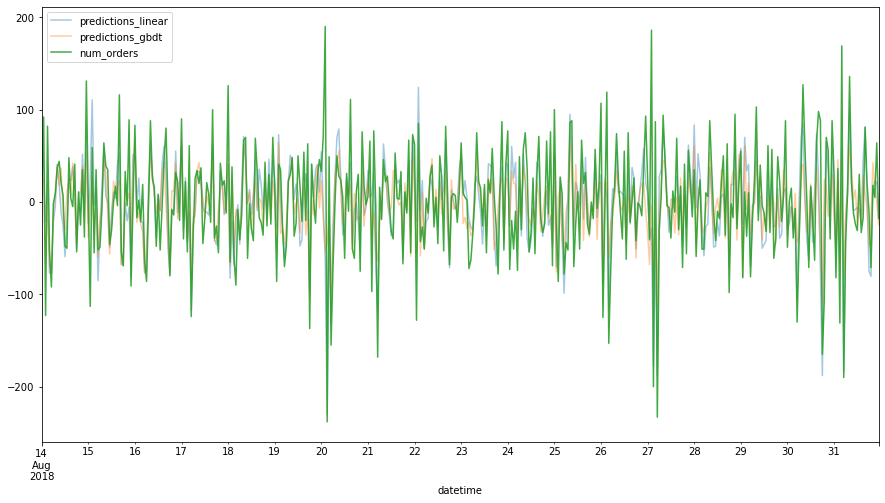

In [102]:
plt.figure(figsize=(15, 8))
prediction1['2018-08-14':'2018-08-31'].plot(alpha=.4)
prediction2['2018-08-14':'2018-08-31'].plot(alpha=.4)
real_values['2018-08-14':'2018-08-31'].plot(alpha=.9)
plt.legend()

На графиках можно видеть, что существенные расхождения есть на пиковых значениях. В среднем у обеих моделей результаты близки к реальным значениям.

## Вывод:
**Задача: "Значение метрики RMSE на тестовой выборке должно быть не больше 48."**

**С поставленной задачей справилась все модели. Лучшей была LinearRegression с результатом RMSE=40.30**
* Мы изучили данные по количеству заказов такси в аэропортах. Нашли закономерности. Есть общий тренд на увеличение количества заказов с начала марта по конец августа. Дневные пики скорее всего связаны с расписанием полетов. Недельный пик приходится на понедельник - день максимальной деловой активности и командировок.
* мы нашли интересную закономерность, что при увеличении числа отстающих значений увеличивается качество предсказания.